In [1]:
!apt install swig cmake

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,395 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 121920 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

In [2]:
!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit1/requirements-unit1.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 57.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of gymnasium[box2d] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 36.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 77.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none

In [3]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
env = gym.make('LunarLander-v2',
            gravity=-10.0,
            enable_wind=True,
            wind_power=15.0,
            turbulence_power=1.5,
            max_episode_steps=600,)
env.reset(seed=42)

# Play one complete episode with random actions
while True:
    action = env.action_space.sample()
    _, _, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break

env.close()

In [5]:

class DQN(torch.nn.Module):
    def __init__(self, state_size=8, action_size=4, hidden_size=64, num_hidden_layers=2, activation=torch.relu):
        super(DQN, self).__init__()
        self.num_hidden_layers = num_hidden_layers

        # Define the input layer
        self.input_layer = torch.nn.Linear(state_size, hidden_size)

        # Define the hidden layers
        self.hidden_layers = torch.nn.ModuleList([
            torch.nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)
        ])

        # Define the output layer
        self.output_layer = torch.nn.Linear(hidden_size, action_size)

        # Activation function
        self.activation = activation

    def forward(self, state):
        x = self.activation(self.input_layer(state))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        return self.output_layer(x)

In [6]:
import random
from collections import deque

class ReplayBuffer:
    def __init__(self, buffer_size=10000):
        self.buffer = deque(maxlen=buffer_size)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.stack(states), actions, rewards, np.stack(next_states), dones

    def __len__(self):
        return len(self.buffer)

In [7]:
class DQNAgent:
    def __init__(self, state_size=8, action_size=4, hidden_size=64,
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64, optimizer='adam', activation=torch.relu, num_hidden_layers=2):
        # Select device to train on (if CUDA available, use it, otherwise use CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Discount factor for future rewards
        self.gamma = gamma

        # Batch size for sampling from the replay memory
        self.batch_size = batch_size

        # Number of possible actions
        self.action_size = action_size

        # Initialize the Q-Network and Target Network with the given state size, action size and hidden layer size
        # Move the networks to the selected device
        self.q_network = DQN(state_size, action_size, hidden_size, activation=activation).to(self.device)
        self.target_network = DQN(state_size, action_size, hidden_size, activation=activation).to(self.device)

        # Set weights of target network to be the same as those of the q network
        self.target_network.load_state_dict(self.q_network.state_dict())

        # Set target network to evaluation mode
        self.target_network.eval()

        if optimizer == 'adam':
            self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        elif optimizer == 'sgd':
            self.optimizer = optim.SGD(self.q_network.parameters(), lr=learning_rate)

        # Initialize the replay memory
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        # Store the experience in memory
        self.memory.push(state, action, reward, next_state, done)

        # If there are enough experiences in memory, perform a learning step
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        # If a randomly chosen value is greater than eps
        if random.random() > eps:
            # Convert state to a PyTorch tensor and set network to evaluation mode
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            self.q_network.eval()

            # With no gradient updates, get the action values from the DQN
            with torch.no_grad():
                action_values = self.q_network(state)

            # Revert to training mode and return action
            self.q_network.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            # Return a random action for random value > eps
            return random.choice(np.arange(self.action_size))

    def update_model(self):
        # Sample a batch of experiences from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert numpy arrays to PyTorch tensors
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        # Get maximum Q-value for the next states from target network
        next_q_values = self.target_network(next_states).max(1)[0].detach()

        # Compute the expected Q-values
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute the loss between the current and expected Q values
        loss = torch.nn.MSELoss()(q_values, expected_q_values)

        # Zero all gradients
        self.optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Step the optimizer
        self.optimizer.step()

    def update_target_network(self):
      self.target_network.load_state_dict(self.q_network.state_dict())

In [12]:
from collections import deque

def train(agent, env, n_episodes=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, target_update=10):
    # Initialize the scores list and scores window
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start

    # Loop over episodes
    for i_episode in range(1, n_episodes + 1):

        # Reset environment and score at the start of each episode
        state, _ = env.reset()
        score = 0

        # Loop over steps
        while True:

            # Select an action using current agent policy then apply in environment
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Update the agent, state, and score
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward

            # End the episode if done
            if done:
                break

        # At the end of episode append and save scores
        scores_window.append(score)
        scores.append(score)

        # Decrease epsilon
        eps = max(eps_end, eps_decay * eps)

        # Update target network every target_update episodes
        if i_episode % target_update == 0:
            agent.update_target_network()

        # Print average score every 100 episodes
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        # This environment is considered to be solved for a mean score of 200 or greater, so stop training.
        if i_episode % 100 == 0 and np.mean(scores_window) >= 200:
            break

    return scores

In [10]:
def plot_scores(scores, title):
    plt.figure(figsize=(10, 5))
    plt.plot(scores, color='b', linestyle='-')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

Episode 100	Average Score: -129.59


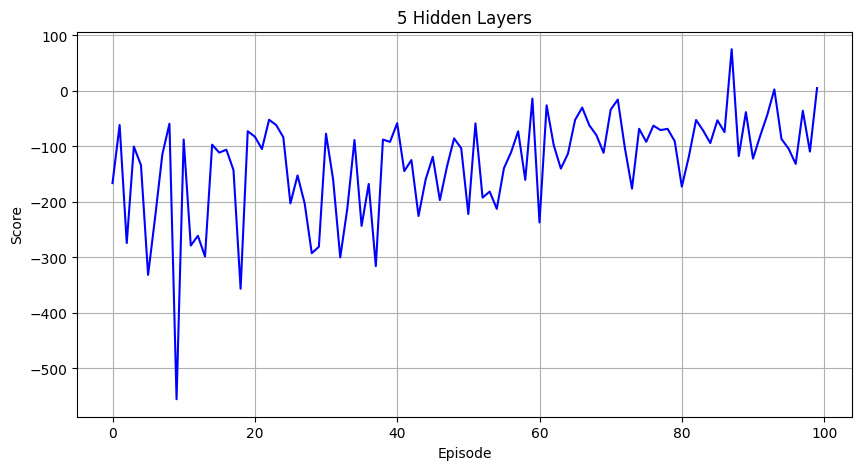

In [13]:
def train_and_plot(agent, env, title):
    scores = train(agent, env)
    plot_scores(scores, title)

env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent_baseline = DQNAgent(state_size, action_size, optimizer='adam')
agent_sgd = DQNAgent(state_size, action_size, optimizer='sgd')
agent_tanh = DQNAgent(state_size, action_size, hidden_size=128, activation=torch.tanh)
agent_leaky_ReLU = DQNAgent(state_size, action_size, hidden_size=128, activation=torch.nn.LeakyReLU()) # Default negative slope of .01
agent_128 = DQNAgent(state_size, action_size, hidden_size=128)
agent_256 = DQNAgent(state_size, action_size, hidden_size=256)
agent_gamma_98 = DQNAgent(state_size, action_size, gamma=0.98)
agent_gamma_95 = DQNAgent(state_size, action_size, gamma=0.95)
agent_hidden_5 = DQNAgent(state_size, action_size, num_hidden_layers=5)
agent_hidden_20 = DQNAgent(state_size, action_size, num_hidden_layers=20)


#train_and_plot(agent_baseline, env, "Baseline")
#train_and_plot(agent_sgd, env, "SGD Optimizer")
#train_and_plot(agent_tanh, env, "Tanh Activation")
#train_and_plot(agent_leaky_ReLU, env, "Leaky ReLU Activation")
#train_and_plot(agent_128, env, "128 Hidden Units")
#train_and_plot(agent_256, env, "256 Hidden Units")
#train_and_plot(agent_gamma_98, env, "Discount Factor of 0.98")
#train_and_plot(agent_gamma_95, env, "Discount Factor of 0.95")
train_and_plot(agent_hidden_5, env, "5 Hidden Layers")
#train_and_plot(agent_hidden_20, env, "20 Hidden Layers")